### Let's create a visualisation of the average message length throughout a year or season

Import the used packages.

In [51]:
from pathlib import Path
from loguru import logger
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tomllib

Use the same way as the notebook in the course folder to get the data.

In [52]:
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': 'whatsapp.parq',
 'inputpath': 'whatsapp.csv',
 'datetime_format': '%d-%m-%Y %H:%M'}

In [53]:
root = Path("..").resolve()
processed = root / Path(config["processed"])
raw = root / Path(config["raw"])
datafile = processed / config["current"]
if not datafile.exists():
    logger.warning(
        f"{datafile} does not exist. First run src/preprocess.py, and check the timestamp!"
    )

In [54]:
base_dataframe = pd.read_parquet(datafile)
base_dataframe.dtypes
base_dataframe.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week
0,2024-04-29 15:41:00,Open trainingen: Ik wil jullie graag een zo la...,bellowing-tarsier,False,False,396,False,worktimes,15:41:00,0
1,2024-04-29 15:41:00,Data: dinsdag 28 mei donderdag 30 mei dinsdagd...,bellowing-tarsier,False,False,121,False,worktimes,15:41:00,0
2,2024-04-29 15:43:00,Ik ga er vanuit dat iedereen erbij is. Ook voo...,bellowing-tarsier,False,False,114,False,worktimes,15:43:00,0
3,2024-04-29 15:45:00,De voorbereiding is vrijwel rond; volgt binnen...,bellowing-tarsier,False,False,85,False,worktimes,15:45:00,0
4,2024-04-29 15:47:00,Heb je vragen of is iets niet duidelijk; geef ...,bellowing-tarsier,False,False,54,False,worktimes,15:47:00,0


Voeg de D

In [ ]:
base_dataframe["day_of_month"] = base_dataframe["timestamp"].dt.day
base_dataframe["day"] = base_dataframe["timestamp"].dt.day_name()
base_dataframe["month"] = base_dataframe["timestamp"].dt.month
base_dataframe["month"] = base_dataframe["timestamp"].dt.month_name()
base_dataframe["year"] = base_dataframe["timestamp"].dt.year
base_dataframe.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,day,month,year
0,2024-04-29 15:41:00,Open trainingen: Ik wil jullie graag een zo la...,bellowing-tarsier,False,False,396,False,worktimes,15:41:00,29,Monday,April,2024
1,2024-04-29 15:41:00,Data: dinsdag 28 mei donderdag 30 mei dinsdagd...,bellowing-tarsier,False,False,121,False,worktimes,15:41:00,29,Monday,April,2024
2,2024-04-29 15:43:00,Ik ga er vanuit dat iedereen erbij is. Ook voo...,bellowing-tarsier,False,False,114,False,worktimes,15:43:00,29,Monday,April,2024
3,2024-04-29 15:45:00,De voorbereiding is vrijwel rond; volgt binnen...,bellowing-tarsier,False,False,85,False,worktimes,15:45:00,29,Monday,April,2024
4,2024-04-29 15:47:00,Heb je vragen of is iets niet duidelijk; geef ...,bellowing-tarsier,False,False,54,False,worktimes,15:47:00,29,Monday,April,2024


Show number of messages per year.

In [94]:
no_of_messages = (
    base_dataframe[["year", "month", "message"]]
    .groupby("year")
    .count()
    .sort_values("year", ascending=True)
)
no_of_messages

,month,message
year,,
2020,1447,1447
2021,2916,2916
2022,4560,4560
2023,593,593
2024,1518,1518
2025,408,408


Count the number of messages per day and group them.

In [78]:
month_day_count = base_dataframe.groupby(["month", "day_of_week"]).size().unstack(fill_value = 0)
average_per_day = month_day_count.mean(axis=0)

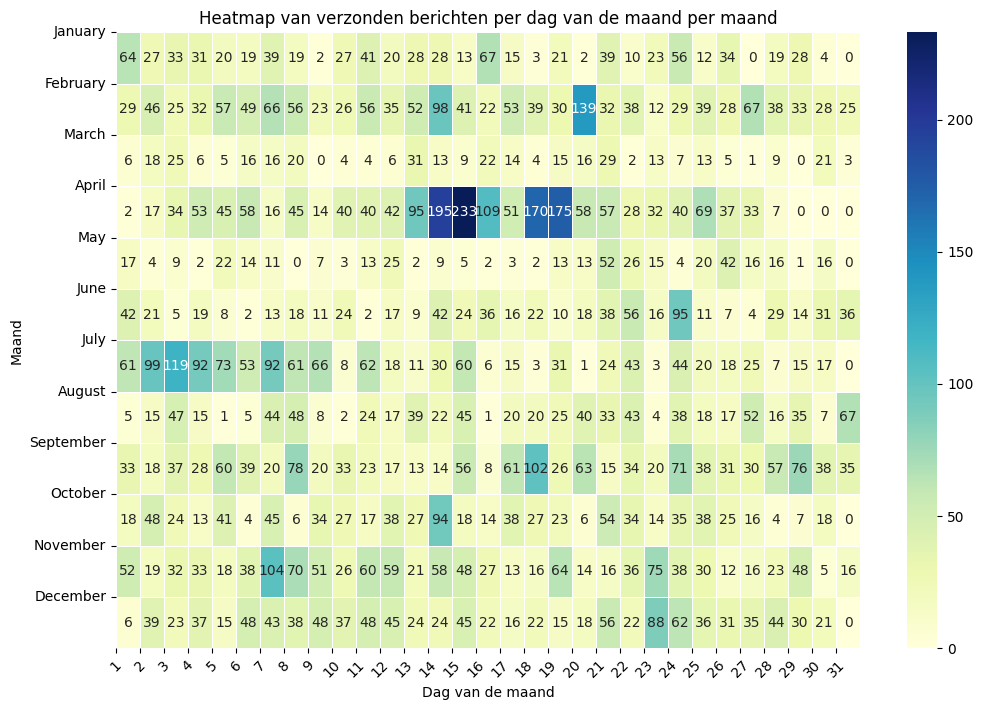

In [82]:
plt.figure(figsize=(12, 8))
sns.heatmap(month_day_count, annot=True, fmt="d", linewidths=0.5, cmap="YlGnBu")
plt.xticks(
    ticks=range(31),
    labels=range(1, 32),
    rotation=45
)

plt.yticks(
    ticks=range(12),
    labels=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
    rotation=0
)

plt.title("Heatmap van verzonden berichten per dag van de maand per maand")
plt.xlabel("Dag van de maand")
plt.ylabel("Maand")
plt.show()